In [2]:
import json
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from scipy.special import stirling2
import math
from copy import copy

In [3]:
status_codes = {
    1: 'LOADED',
    2: 'OPTIMAL',
    3: 'INFEASIBLE',
    4: 'INF_OR_UNBD',
    5: 'UNBOUNDED',
    6: 'CUTOFF',
    7: 'ITERATION_LIMIT',
    8: 'NODE_LIMIT',
    9: 'TIME_LIMIT',
    10: 'SOLUTION_LIMIT',
    11: 'INTERRUPTED',
    12: 'NUMERIC',
    13: 'SUBOPTIMAL',
    14: 'INPROGRESS',
    15: 'USER_OBJ_LIMIT'
}

In [4]:
rng = np.random.default_rng(8)

# SDP for model free dependence test

Have previously used factorization of moments under an assumption of independent species (but with no assumed model) as constraints for an (in)dependence test for a pair of genes, essentially a 'capture efficiency corrected correlation test'. This produces very good results, able to detect very weak interaction in simulated data, and suggesting a reasonable number of interacting pairs when given real single cell data.

However, only used factorization of order 2 cross moment in order 1 moments:

$$
\mathbb{E}[X_{1}X_{2}] = \mathbb{E}[X_{1}]\mathbb{E}[X_{2}]
$$

So try using the new SDP approach to include factorization of all cross moments up to order $d$:

$$
\mathbb{E}[X_{1}^{\alpha_1} X_{2}^{\alpha_2}] = \mathbb{E}[X_{1}^{\alpha_1}]\mathbb{E}[X_{2}^{\alpha_2}] \quad \forall \vert \alpha \vert \le d
$$

and the SDP condition for valid moments (*):

$$
M_{d}^{s}(y) \succeq 0 \quad \forall s \in \{0, \ldots, S\}
$$

Investigate if there are any improvements / changes to results:
- may detect weaker interaction
- may lead to false positives
- (*) SDP condition may be pointless / false positives

## Code

Use interacting birth-death (simplest 2 species code) & interacting telegraph (newer code) code to create 2 species model free feasibility test

In [5]:
def compute_order(alpha):
    order = 0
    for alpha_i in alpha:
        order += alpha_i
    return order

In [6]:
def compute_Nd(d, S):
    '''Number of moments of order <= d (S species)'''
    Nd = math.factorial(S + d) // (math.factorial(d) * math.factorial(S))
    return Nd

In [7]:
def compute_powers(d, S):
    '''Compute the Nd powers of order <= d (S species)'''

    # all powers
    powers = [[0 for s in range(S)]]

    # powers of order d = 0
    powers_prev = [[0 for s in range(S)]]

    # for order d = 1, ..., d
    for order in range(1, d + 1):

        # store powers of order d
        powers_current = []

        # for each power of order d - 1
        for alpha in powers_prev:

            # for each index
            for i in range(S):

                # add 1 to power at index
                alpha_new = copy(alpha)
                alpha_new[i] += 1

                # store (avoid repeats)
                if alpha_new not in powers_current:
                    powers_current.append(alpha_new)

        # update d - 1 powers
        powers += powers_current

        # update overall powers
        powers_prev = powers_current

    return powers

In [8]:
def compute_B(beta, d, U, S):
    '''
    Capture efficiency moment scaling matrix

    Args:
        beta: per cell capture efficiency sample
        d: maximum moment order used
        U: unobserved species indices
        S: number of species

    Returns:
        B: (Nd, Nd) matrix of coefficients
    '''

    # number of moments of order <= d
    Nd = compute_Nd(d, S)

    # compute powers of order <= d
    powers = compute_powers(d, S)

    # compute beta moments of order <= d
    y_beta = np.zeros(d + 1)
    for l in range(d + 1):
        y_beta[l] = np.mean(beta**l)

    def falling_factorial(n, k):
        val = 1
        for i in range(k):
            val *= (n - i)
        return val

    def binomial_moment(n, p, l):
        val = 0
        for k in range(l + 1):
            val += falling_factorial(n, k) * stirling2(l, k) * p**k
        return val

    # setup matrix
    B = np.zeros((Nd, Nd))

    p = sp.Symbol('p')
    xs = sp.symbols([f'x{i}' for i in range(S)])

    # for each moment power
    for row, alpha in enumerate(powers):

        # setup polynomail
        poly_alpha = 1

        # for each species
        for i in range(S):

            # unobserved: no capture efficiency
            if i in U:
                moment = xs[i]**alpha[i]

            # observed: compute moment expression for E[Xi^alphai] in xi
            else:
                moment = binomial_moment(xs[i], p, alpha[i])
            
            poly = sp.Poly(moment, p, xs[i])

            # multiply
            poly_alpha = poly_alpha * poly

        # loop over terms
        for (beta_power, *xs_power), coeff in zip(poly_alpha.monoms(), poly_alpha.coeffs()):

            # get matrix index
            col = powers.index(xs_power)

            B[row, col] += coeff * y_beta[beta_power]

    return B

In [9]:
def add_powers(*powers, S):
    plus = [0 for i in range(S)]
    for i in range(S):
        for power in powers:
            plus[i] += power[i]
    return plus

In [10]:
def construct_M_0(y, d, S):
    '''Moment matrix variable constructor (s = 0).'''
    D = math.floor(d / 2)
    powers_D = compute_powers(D, S)
    powers_d = compute_powers(d, S)
    ND = compute_Nd(D, S)
    M_0 = [[0 for j in range(ND)] for i in range(ND)]
    for alpha_index, alpha in enumerate(powers_D):
        for beta_index, beta in enumerate(powers_D):
            plus = add_powers(alpha, beta, S=S)
            plus_index = powers_d.index(plus)
            M_0[alpha_index][beta_index] = y[plus_index].item()
    M_0 = gp.MVar.fromlist(M_0)
    return M_0

In [11]:
def construct_M_s(y, d, s, S):
    '''Moment matrix variable constructor (s).'''
    D = math.floor((d - 1) / 2)
    powers_D = compute_powers(D, S)
    powers_d = compute_powers(d, S)
    ND = compute_Nd(D, S)
    M_s = [[0 for j in range(ND)] for i in range(ND)]
    e_s = [1 if i == (s - 1) else 0 for i in range(S)]
    for alpha_index, alpha in enumerate(powers_D):
        for beta_index, beta in enumerate(powers_D):
            plus = add_powers(alpha, beta, e_s, S=S)
            plus_index = powers_d.index(plus)
            M_s[alpha_index][beta_index] = y[plus_index].item()
    M_s = gp.MVar.fromlist(M_s)
    return M_s

In [12]:
def base_model(model, OB_bounds, beta, d, U, time_limit=300):
    '''
    Construct 'base model' with semidefinite constraints removed to give NLP

    Args:
        model: empty gurobi model object
        OB_bounds: confidence intervals on observed moments up to order d
        beta: capture efficiency vector
        d: maximum moment order used
        U: unobserved species indices
        time_limit: optimization time limit

    Returns:
        model: gurobi model object with NLP constraints (all but semidefinite)
        variables: dict for model variable reference
    '''

    # model settings
    model.Params.TimeLimit = time_limit

    # helpful values
    S = 2
    Nd = compute_Nd(d, S)

    # variables
    y = model.addMVar(shape=Nd, vtype=GRB.CONTINUOUS, name="y", lb=0)

    # variable dict
    variables = {
        'y': y
    }

    # moment matrices
    M_0 = construct_M_0(y, d, S)
    variables['M_0'] = M_0
    for s in range(1, S + 1):
        M_s = construct_M_s(y, d, s, S)
        variables[f'M_{s}'] = M_s
    
    # constraints

    # confidence interval bounds on OB moments
    y_lb = OB_bounds[0, :]
    y_ub = OB_bounds[1, :]

    # B scaling matrix
    B = compute_B(beta, d, U, S)

    # moment bounds
    model.addConstr(B @ y <= y_ub, name="y_UB")
    model.addConstr(B @ y >= y_lb, name="y_LB")

    # factorization bounds
    powers = compute_powers(d, S)
    for i, alpha in enumerate(powers):

        # E[X1^a1 X2^a2] = E[X1^a1] E[X2^a2]
        if (alpha[0] > 0) and (alpha[1] > 0):
            j = powers.index([alpha[0], 0])
            k = powers.index([0, alpha[1]])
            model.addConstr(y[i] == y[j] * y[k], name=f"Moment_factorization_{alpha[0]}_({alpha[1]})")

    # base
    model.addConstr(y[0] == 1, name="y0_base")

    return model, variables

In [13]:
def optimize(model):
    '''Optimize model with no objective, return status.'''

    # optimize
    model.setObjective(0, GRB.MINIMIZE)
    model.optimize()
    status = status_codes[model.status]

    return model, status

In [66]:
def semidefinite_cut_all(model, variables, S, print_evals=False, eval_eps=10**-6, printing=True):
    '''
    Check semidefinite feasibility of NLP feasible point
    Feasible: stop
    Infeasible: add cutting plane (ALL negative eigenvalues)

    Args:
        model: optimized NLP model
        variables: model variable reference dict
        print_evals: option to display moment matrix eigenvalues (semidefinite condition)

    Returns:
        model: model with any cutting planes added
        bool: semidefinite feasibility status
    '''

    # data list
    data = []

    # moment matrix values
    for s in range(S + 1):
        data.append(
            {f'M_val': variables[f'M_{s}'].X}
        )

    # eigen information
    for s in range(S + 1):
        evals_s, evecs_s = np.linalg.eigh(data[s]['M_val'])
        data[s]['evals'] = evals_s
        data[s]['evecs'] = evecs_s

    if print_evals:
        print("Moment matices eigenvalues:")
        for s in range(S + 1):
            print(data[s]['evals'])

    # check if all positive eigenvalues
    positive = True
    for s in range(S + 1):
        if not (data[s]['evals'] >= -eval_eps).all():
            positive = False
            break

    # positive eigenvalues
    if positive:

        if printing: print("SDP feasible\n")
    
        return model, True

    # negative eigenvalue
    else:

        if printing: print("SDP infeasible\n")

        # for each matrix
        for s in range(S + 1):

            # for each M_s eigenvalue
            for i, lam in enumerate(data[s]['evals']):

                # if negative (sufficiently)
                if lam < -eval_eps:

                    # get evector
                    v = data[s]['evecs'][:, i]

                    # add cutting plane
                    # model.addConstr(np.kron(v, v.T) @ variables[f'M_{s}'].reshape(-1) >= 0, name=f"Cut_{s}")
                    model.addConstr(v.T @ variables[f'M_{s}'] @ v >= 0, name=f"Cut_{s}")
                
                    if printing: print(f"M_{s} cut added")

        if printing: print("")

    return model, False

In [15]:
def feasibility_test(OB_bounds, beta, d, S, U, print_evals=False, eval_eps=10**-6, printing=True):
    '''
    Full feasibility test of birth death model via following algorithm

    Optimize NLP
    Infeasible: stop
    Feasible: check SDP feasibility
        Feasible: stop
        Infeasible: add cutting plane and return to NLP step

    Args:
        OB_bounds: confidence intervals on observed moments up to order d
        beta: capture efficiency vector
        d: maximum moment order used
        U: unobserved species indices

    Returns:
        None
    '''

    # silent
    options = {'OutputFlag': 0}

    # environment context
    with gp.Env(params=options) as env:

        # model context
        with gp.Model('test-SDP', env=env) as model:

            # construct base model (no semidefinite constraints)
            model, variables = base_model(model, OB_bounds, beta, d, U)

            # check feasibility
            model, status = optimize(model)

            # while feasible
            while status == "OPTIMAL":

                if printing: print("NLP feasible")

                # check semidefinite feasibility
                model, semidefinite_feas = semidefinite_cut_all(model, variables, S, print_evals=print_evals, eval_eps=eval_eps, printing=printing)

                # semidefinite feasible
                if semidefinite_feas:
                    break

                # semidefinite infeasible
                else:

                    # check feasibility with added cut
                    model, status = optimize(model)

            # if infeasible
            if status == "INFEASIBLE":
                if printing: print("SDP infeasible")

                #model.computeIIS()
                #model.write('test.ilp')

            return status

In [16]:
def bootstrap(sample, d, U, S, N=1000):
    '''
    Estimate bootstrap intervals of sample moments up to order d

    Args:
        sample: integer sample of length n
        d: maximum moment order to estimate
        N: number of bootstrap samples
        S: number of species

    Returns:
        y_bounds: (2, Nd) array of moment confidence intervals
    '''

    # helpful values
    powers = compute_powers(d, S)
    Nd = compute_Nd(d, S)

    # get sample size
    n = len(sample)

    # separate sample pairs
    x1_sample = [x[0] for x in sample]
    x2_sample = [x[1] for x in sample]

    # convert sample to n x 2 array
    sample = np.array([x1_sample, x2_sample]).T

    # bootstrap to N x n x 2 array
    boot = rng.choice(sample, size=(N, n))

    # split into 2 N x n arrays
    x1_boot = boot[:, :, 0]
    x2_boot = boot[:, :, 1]

    # estimate
    y_bounds = np.zeros((2, Nd))
    for i, alpha in enumerate(powers):

        # check if unobserved species present in moment
        unobserved_moment = False
        for j, alpha_j in enumerate(alpha):
            if (j in U) and (alpha_j > 0):
                unobserved_moment = True

        # unobserved: [0, inf] bounds
        if unobserved_moment:
            y_bounds[:, i] = np.array([0, np.inf])

        # otherwise: estimate
        else:

            # raise boot to powers
            x1_boot_alpha = x1_boot**alpha[0]
            x2_boot_alpha = x2_boot**alpha[1]

            # multiply (N x n)
            boot_alpha = x1_boot_alpha * x2_boot_alpha

            # mean over sample axis (N x 1)
            moment_estimates = np.mean(boot_alpha, axis=1)

            # quantile over boot axis (2 x 1)
            moment_interval = np.quantile(moment_estimates, [0.025, 0.975])

            # store
            y_bounds[:, i] = moment_interval

    return y_bounds

In [17]:
def downsample_data(sample, b):

    n = len(sample)

    # capture efficiency
    if b == 0:
        beta = np.ones(n)
    else:
        beta = rng.beta(1, b, size=1000)

    # split
    x1_sample = [x[0] for x in sample]
    x2_sample = [x[1] for x in sample]

    # downsample
    x1_downsample = rng.binomial(x1_sample, beta).tolist()
    x2_downsample = rng.binomial(x2_sample, beta).tolist()

    # combine
    downsample = list(zip(x1_downsample, x2_downsample))

    return downsample, beta

## Test

In [18]:
from interaction_inference.simulation import gillespie_birth_death

In [19]:
# settings
k1 = 5
k2 = 1
k_reg = 1
b = 1
n = 1000
N = 1000

# sample
params = {
    'k_tx_1': k1,
    'k_tx_2': k1,
    'k_deg_1': k2,
    'k_deg_2': k2,
    'k_reg': k_reg
}
sample = gillespie_birth_death(params, n)

# downsample
downsample, beta = downsample_data(sample, b)

# mean expression level
print(f"Mean expression {np.mean(downsample)}")

Mean expression 1.027


In [20]:
# settings
for d in [2, 3]:

    # bootstrap
    y_bounds = bootstrap(downsample, d, S=2, U=[])

    # test feasibility
    feasibility_test(y_bounds, beta, d, S=2, U=[])

NLP feasible
SDP feasible

NLP feasible
SDP feasible



See that increasing maximum moment order from 2 to 3 allows us to conclude infeasibility of interacting data.

Suggests that additional factorization / SDP constraints may help model free test.

Investigate further using a gridtest

## Basic model free test

Implement the basic dependence test used previously, where only the first cross moment is factorized into means (adjusted by capture), for use in comparison test.

In [18]:
def previous_base_model(model, OB_bounds, beta, time_limit=300):
    '''
    Construct 'base model' with semidefinite constraints removed to give NLP

    Args:
        model: empty gurobi model object
        OB_bounds: confidence intervals on observed moments up to order d
        beta: capture efficiency vector
        d: maximum moment order used
        U: unobserved species indices
        time_limit: optimization time limit

    Returns:
        model: gurobi model object with NLP constraints (all but semidefinite)
        variables: dict for model variable reference
    '''

    # model settings
    model.Params.TimeLimit = time_limit

    # helpful values
    S = 2
    d = 2
    Nd = compute_Nd(d, S)

    # variables
    y = model.addMVar(shape=Nd, vtype=GRB.CONTINUOUS, name="y", lb=0)

    # variable dict
    variables = {
        'y': y
    }
    
    # constraints

    # confidence interval bounds on OB moments
    y_lb = OB_bounds[0, :]
    y_ub = OB_bounds[1, :]

    # B scaling matrix
    B = compute_B(beta, d, [], S)

    # moment bounds
    model.addConstr(B @ y <= y_ub, name="y_UB")
    model.addConstr(B @ y >= y_lb, name="y_LB")

    # factorization bound
    powers = compute_powers(d, S)
    i = powers.index([1, 1])
    j = powers.index([0, 1])
    k = powers.index([1, 0])
    model.addConstr(y[i] == y[j] * y[k], name=f"Moment_factorization_1_1")

    return model, variables

In [19]:
def old_base_model(model, OB_bounds, beta, time_limit=300):
    '''
    Construct 'base model' with semidefinite constraints removed to give NLP

    Args:
        model: empty gurobi model object
        OB_bounds: confidence intervals on observed moments up to order d
        beta: capture efficiency vector
        d: maximum moment order used
        U: unobserved species indices
        time_limit: optimization time limit

    Returns:
        model: gurobi model object with NLP constraints (all but semidefinite)
        variables: dict for model variable reference
    '''

    # model settings
    model.Params.TimeLimit = time_limit

    # helpful values
    E_beta = np.mean(beta)
    E_beta_sq = np.mean(beta**2)

    # variables
    E_x1_x2 = model.addVar(vtype=GRB.CONTINUOUS, name="E_x1_x2", lb=0)
    E_x1 = model.addVar(vtype=GRB.CONTINUOUS, name="E_x1", lb=0)
    E_x2 = model.addVar(vtype=GRB.CONTINUOUS, name="E_x2", lb=0)

    # variable dict
    variables = {
        'E_x1_x2': E_x1_x2,
        'E_x1': E_x1,
        'E_x2': E_x2
    }
    
    # constraints

    # confidence interval bounds on OB moments
    # E[X1] scaled bounds
    model.addConstr(E_beta * E_x1 <= OB_bounds[1, 1], name="E_x1_UB")
    model.addConstr(E_beta * E_x1 >= OB_bounds[0, 1], name="E_x1_LB")
    # E[X2] scaled bounds
    model.addConstr(E_beta * E_x2 <= OB_bounds[1, 2], name="E_x2_UB")
    model.addConstr(E_beta * E_x2 >= OB_bounds[0, 2], name="E_x2_LB")
    # E[X1X2] scaled bounds
    model.addConstr(E_beta_sq * E_x1_x2 <= OB_bounds[1, 4], name="E_x1_x2_UB")
    model.addConstr(E_beta_sq * E_x1_x2 >= OB_bounds[0, 4], name="E_x1_x2_LB")

    # factorization
    model.addConstr(E_x1_x2 == E_x1 * E_x2, name=f"Moment_factorization")

    return model, variables

In [20]:
def previous_feasibility_test(OB_bounds, beta, printing=True):
    '''
    Feasibility test of E[X1 * X2] = E[X1] * E[X2] (adjusted for capture)

    Args:
        OB_bounds: confidence intervals on observed moments up to order d
        beta: capture efficiency vector

    Returns:
        None
    '''

    # silent
    options = {'OutputFlag': 0}

    # environment context
    with gp.Env(params=options) as env:

        # model context
        with gp.Model('test-SDP', env=env) as model:

            # construct base model (no semidefinite constraints)
            model, variables = previous_base_model(model, OB_bounds, beta)

            # check feasibility
            model, status = optimize(model)

            if status == "OPTIMAL":
                if printing: print("feasible")

            elif status == "INFEASIBLE":
                if printing: print("infeasible")

                #model.computeIIS()
                #model.write('test.ilp')

            else:
                if printing: print(f"Status {status}")

    return status

In [21]:
def old_feasibility_test(OB_bounds, beta, printing=True):
    '''
    Feasibility test of E[X1 * X2] = E[X1] * E[X2] (adjusted for capture)

    Args:
        OB_bounds: confidence intervals on observed moments up to order d
        beta: capture efficiency vector

    Returns:
        None
    '''

    # silent
    options = {'OutputFlag': 0}

    # environment context
    with gp.Env(params=options) as env:

        # model context
        with gp.Model('test-SDP', env=env) as model:

            # construct base model (no semidefinite constraints)
            model, variables = old_base_model(model, OB_bounds, beta)

            # check feasibility
            model, status = optimize(model)

            if status == "OPTIMAL":
                if printing: print("feasible")

            elif status == "INFEASIBLE":
                if printing: print("infeasible")

                #model.computeIIS()
                #model.write('test.ilp')

            else:
                if printing: print(f"Status {status}")

    return status

## Test

In [25]:
# settings
k1 = 5
k2 = 1
k_reg = 1.5
b = 1
n = 1000
N = 1000

# sample
params = {
    'k_tx_1': k1,
    'k_tx_2': k1,
    'k_deg_1': k2,
    'k_deg_2': k2,
    'k_reg': k_reg
}
sample = gillespie_birth_death(params, n)

# downsample
downsample, beta = downsample_data(sample, b)

# mean expression level
print(f"Mean expression {np.mean(downsample)}")

Mean expression 0.9045


In [26]:
# bootstrap
y_bounds = bootstrap(downsample, d=2, S=2, U=[])

# test feasibility
previous_feasibility_test(y_bounds, beta)

# test feasibility
old_feasibility_test(y_bounds, beta)

infeasible
infeasible


'INFEASIBLE'

## Comparison

For a grid of interaction strength x capture efficiency samples, use 'old factorization' and new 'SDP factorization' (for a range of d) to run feasibility test for dependence and compare results.

Hopefully increasing d has a positive effect on the dependence detection, and no false positives occur. May tail off as d becomes large.

In [22]:
from tqdm import tqdm

In [36]:
# settings
interaction_values = [10.0, 5.0, 2.0, 1.5, 1.0, 0.75, 0.5, 0.25, 0.1, 0.0] #[0, 0.1, 0.2, 0.3, 0.5, 0.75, 1.0, 2.0, 5.0, 10.0]
capture_values = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1] #[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
runs = 3
rate = 1
n = 1000

# result arrays
shape = (len(interaction_values), len(capture_values))
result_old = np.zeros(shape)
result_2 = np.zeros(shape)
result_3 = np.zeros(shape)
result_5 = np.zeros(shape)
result_10 = np.zeros(shape)

# running
for i in range(runs):

    for j, k_reg in enumerate(tqdm(interaction_values)):

        params = {
            'k_tx_1': rate,
            'k_tx_2': rate,
            'k_deg_1': 1,
            'k_deg_2': 1,
            'k_reg': k_reg
        }

        # simulate
        sample = gillespie_birth_death(params, n)

        for k, b in enumerate(capture_values):

            # downsample
            downsample, beta = downsample_data(sample, b)

            # bootstrap
            y_bounds = bootstrap(downsample, d=10, S=2, U=[])

            # old test
            status = old_feasibility_test(y_bounds, beta, printing=False)
            if status == "INFEASIBLE":
                result_old[j, k] += 1 / runs

            # d=2 test
            N2 = compute_Nd(d=2, S=2)
            status = feasibility_test(y_bounds[:, :N2], beta, d=2, S=2, U=[], printing=False)
            if status == "INFEASIBLE":
                result_2[j, k] += 1 / runs

            # d=3 test
            N3 = compute_Nd(d=3, S=2)
            status = feasibility_test(y_bounds[:, :N3], beta, d=3, S=2, U=[], printing=False)
            if status == "INFEASIBLE":
                result_3[j, k] += 1 / runs

            # d=5 test
            N5 = compute_Nd(d=5, S=2)
            status = feasibility_test(y_bounds[:, :N5], beta, d=5, S=2, U=[], printing=False)
            if status == "INFEASIBLE":
                result_5[j, k] += 1 / runs

            # d=10 test
            N10 = compute_Nd(d=10, S=2)
            status = feasibility_test(y_bounds[:, :N10], beta, d=10, S=2, U=[], printing=False)
            if status == "INFEASIBLE":
                result_10[j, k] += 1 / runs       

100%|██████████| 10/10 [03:00<00:00, 18.06s/it]


In [30]:
from matplotlib.colors import LinearSegmentedColormap

In [31]:
def plot(result_array, title, figsize=(6, 6)):

    fig, axs = plt.subplots(figsize=figsize)

    #fig.suptitle("Infeasibility %")

    #plt.tight_layout()

    cmap = LinearSegmentedColormap.from_list('br', ["b", "w", "r"], N=256)

    vmin, vmax = 0, 1

    img = axs.imshow(result_array, cmap=cmap, vmin=vmin, vmax=vmax)
    axs.set_xlabel("Mean capture efficiency (Beta dist.)")
    axs.set_xticks(range(len(capture_values)))
    axs.set_xticklabels(capture_values)
    axs.set_ylabel("Interaction strength")
    axs.set_yticks(range(len(interaction_values)))
    axs.set_yticklabels(interaction_values)
    axs.set_title(title)

    cbar = plt.colorbar(img, ax=axs)
    cbar.set_label("Infeasibility (%)")

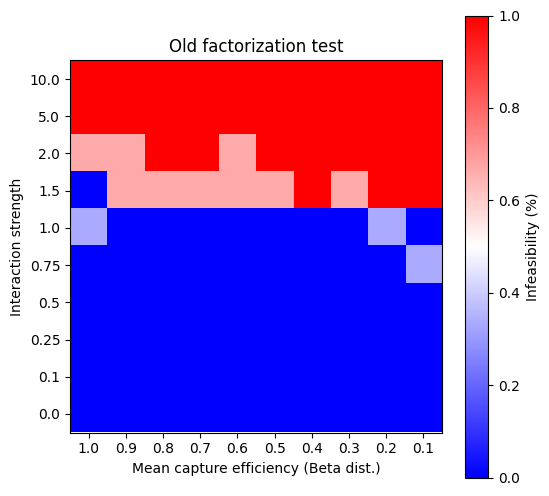

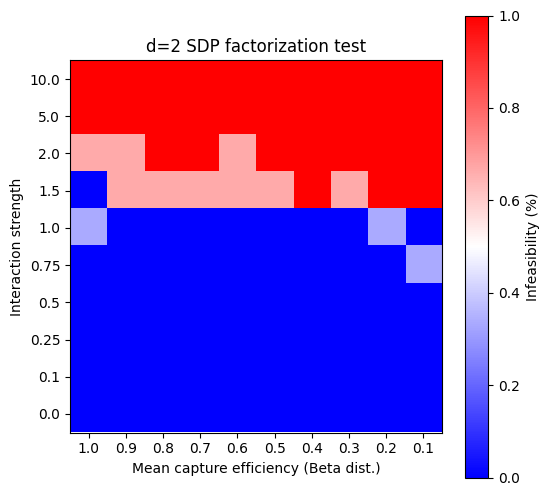

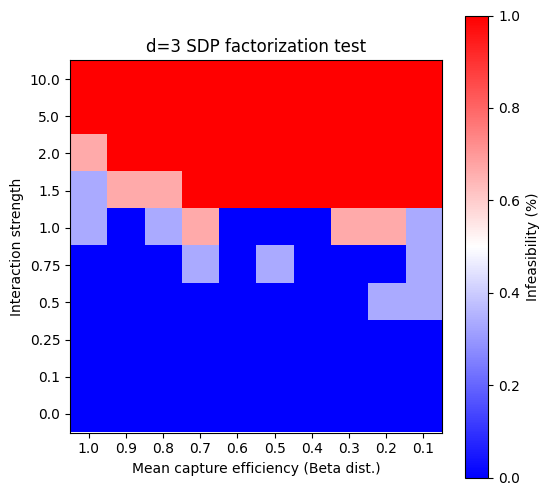

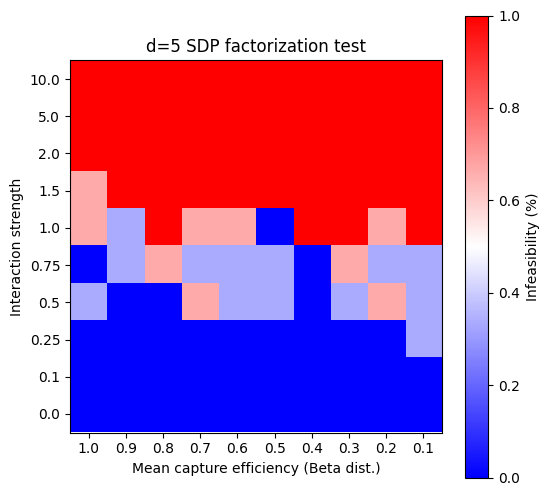

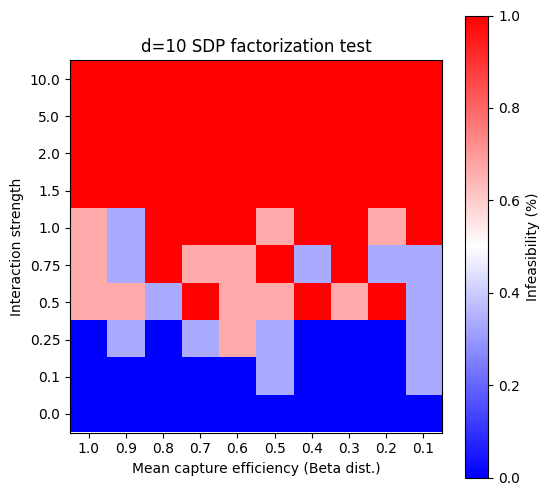

In [38]:
plot(result_old, "Old factorization test")
plot(result_2, "d=2 SDP factorization test")
plot(result_3, "d=3 SDP factorization test")
plot(result_5, "d=5 SDP factorization test")
plot(result_10, "d=10 SDP factorization test")

## Effect of moment order

- Simulate data across a range of interaction strength (fixed capture e.g. 50% mean)
- for each d in large range: optimize and find rough minimum interaction
- plot on graph

In [24]:
from interaction_inference.simulation import gillespie_birth_death

In [71]:
# settings
interaction_values = [10.0, 5.0, 2.0, 1.5, 1.0, 0.75, 0.5, 0.25, 0.1, 0.0]
d_values = range(2, 11)
b = 0.5
runs = 3
rate = 1
n = 1000

# result array
results = np.zeros((runs, len(d_values)))

# for each run
for i in tqdm(range(runs)):

    # for each interaction strength
    for k_reg in tqdm(interaction_values):

        # simulate
        params = {
                'k_tx_1': rate,
                'k_tx_2': rate,
                'k_deg_1': 1,
                'k_deg_2': 1,
                'k_reg': k_reg
            }
        sample = gillespie_birth_death(params, n)

        # downsample
        downsample, beta = downsample_data(sample, b)

        # bootstrap
        y_bounds = bootstrap(downsample, d=d_values[-1], S=2, U=[])

        # for each d
        for j, d in enumerate(d_values):

            # test feasibility
            Nd = compute_Nd(d=d, S=2)
            status = feasibility_test(y_bounds[:, :Nd], beta, d=d, S=2, U=[], printing=False)

            # infeasible: record interaction strength detected
            if status == "INFEASIBLE":
                results[i, j] = k_reg

100%|██████████| 3/3 [01:32<00:00, 30.79s/it]


In [72]:
# average values over runs
results_avg = np.mean(results, axis=0)

Text(0.5, 1.0, 'Effect of moment order on (in)dependence test')

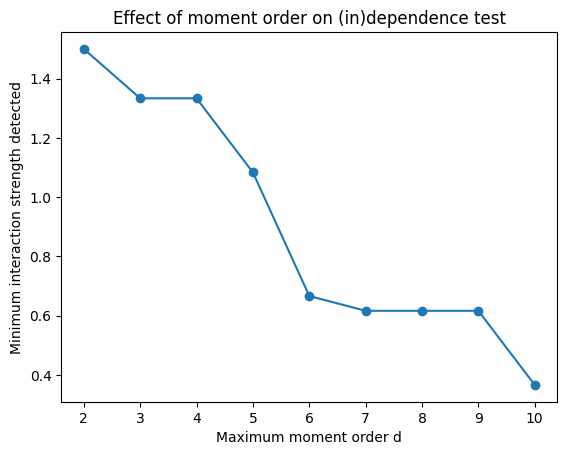

In [73]:
# plot
plt.plot(d_values, results_avg)
plt.scatter(d_values, results_avg)
plt.xlabel("Maximum moment order d")
plt.ylabel("Minimum interaction strength detected")
plt.title("Effect of moment order on (in)dependence test")

See that as we increase d the minimum interaction detected (averaged over several runs) drops.

Unfortunately significantly slow when using d > 10, so hard to see if / when this descent slows.